In [1]:
#pandas, para lectura de datos.
import pandas as pd 

#numpy,  carga de datos en memoria
import numpy as np

#matplotlib, para graficar.
import matplotlib.pyplot as plt 

#Sequential es fundamental para apilar capas que pueden conformar una red neuronal o simplemente una función matématica.   
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler




In [2]:
#Función para graficar

def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [3]:
# Lectura de los datos
#
dataset = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


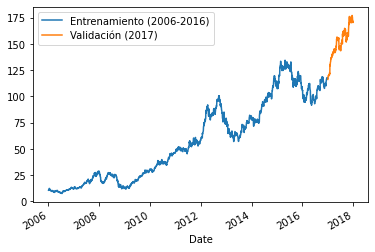

In [4]:
#
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#
set_entrenamiento = dataset[:'2016'].iloc[:,1:2]
set_validacion = dataset['2017':].iloc[:,1:2]

set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()


In [5]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

#time_step =60, m=2768, cantidad de datos del set de entrenamiento: set_entrenamiento.
for i in range(time_step,m):  
    # X: 
    '''
    print("i: ", i)
    print("time_step: ", time_step)
    print("i-time_step: ",i-time_step)
    print("set_entrenamiento_escalado: ",set_entrenamiento_escalado[i-time_step:i,0])
    print("set_entrenamiento_escalado: ",set_entrenamiento_escalado[i,0])
    print("-----------------------------------------------------------------------")
    '''
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])


In [8]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# se debe indicar que la dimension del dato de entrada sera de 60 x 1, siendo 60, la cantidad de datos.
# la salida tiene como tamaño 1, porque se devolvera una cifra correspondiente a la predicciòn.

X_train.shape

(2708, 60, 1)

In [9]:
# Red LSTM

dim_entrada = (X_train.shape[1],1) # 60 ,1 
dim_salida = 1
numero_de_neuronas = 50

modelo = Sequential()
modelo.add(LSTM(units=numero_de_neuronas, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
85/85 [==============================] - 2s 25ms/step - loss: 0.0126
Epoch 2/20
85/85 [==============================] - 2s 24ms/step - loss: 0.0012
Epoch 3/20
85/85 [==============================] - 2s 24ms/step - loss: 8.4053e-04: 0s - loss: 8.5
Epoch 4/20
85/85 [==============================] - 2s 26ms/step - loss: 6.0124e-04
Epoch 5/20
85/85 [==============================] - 2s 24ms/step - loss: 5.4253e-04
Epoch 6/20
85/85 [==============================] - 2s 24ms/step - loss: 4.1931e-04
Epoch 7/20
85/85 [==============================] - 2s 25ms/step - loss: 3.7767e-04
Epoch 8/20
85/85 [==============================] - 2s 24ms/step - loss: 3.5496e-04
Epoch 9/20
85/85 [==============================] - ETA: 0s - loss: 3.2470e-0 - 2s 25ms/step - loss: 3.2470e-04
Epoch 10/20
85/85 [==============================] - 2s 24ms/step - loss: 3.1484e-04
Epoch 11/20
85/85 [==============================] - 2s 24ms/step - loss: 2.7104e-04
Epoch 12/20
85/85 [===================

In [11]:
len(x_test)

251

In [12]:
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [13]:
prediccion = modelo.predict(X_test)


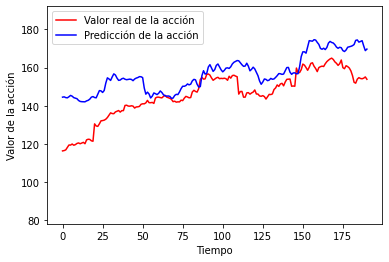

In [15]:
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)

In [ ]:
# Hay una diferencia de al menos 10$ entre el valor predicho y el real.